Prepare the data. I have 8 input features and 21 target outputs.

In [1]:
import pandas as pd

# load dataset
data = pd.read_csv('data/material_response.csv')
print(data.info())

# print header labels
labels = data.columns.tolist()
x_labels = labels[0:8]
y_labels = labels[8:]
print("xlabels:", x_labels)
print("ylabels:", y_labels)

# extract features and targets
x = data[x_labels].values
y = data[y_labels].values

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2813 entries, 0 to 2812
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ε11     2813 non-null   float64
 1   ε22     2813 non-null   float64
 2   ε12     2813 non-null   float64
 3   ɣ13     2813 non-null   float64
 4   ɣ23     2813 non-null   float64
 5   κ11     2813 non-null   float64
 6   κ22     2813 non-null   float64
 7   κ12     2813 non-null   float64
 8   A11     2813 non-null   float64
 9   A22     2813 non-null   float64
 10  A33     2813 non-null   float64
 11  A23     2813 non-null   float64
 12  A13     2813 non-null   float64
 13  A12     2813 non-null   float64
 14  B11     2813 non-null   float64
 15  B22     2813 non-null   float64
 16  B33     2813 non-null   float64
 17  B23     2813 non-null   float64
 18  B13     2813 non-null   float64
 19  B12     2813 non-null   float64
 20  D11     2813 non-null   float64
 21  D22     2813 non-null   float64
 22  

To run using cuda: 
- Check if cuda is available: ```nvidia-smi```
- Install torch with available cuda version: ```pip install torch --index-url https://download.pytorch.org/whl/cu128```

In [2]:
import torch

# run on GPU if available
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"

Shuffle and split the dataset by 80, 10 and 10 percent for training, cross-validation and testing

In [3]:
# z score normalization
x_mean = x.mean(axis=0)
x_std = x.std(axis=0)
y_mean = y.mean(axis=0)
y_std = y.std(axis=0)
x_normalized = (x - x_mean) / x_std
y_normalized = (y - y_mean) / y_std

# convert to torch tensors and move to device
x_tensor = torch.tensor(x_normalized, dtype=torch.float32).to(device)
y_tensor = torch.tensor(y_normalized, dtype=torch.float32).to(device)

# shuffle and split dataset
torch.manual_seed(42)
shuffle_indices = torch.randperm(x_tensor.shape[0])
x_shuffled = x_tensor[shuffle_indices]
y_shuffled = y_tensor[shuffle_indices]
    
n1 = int(0.8 * x_tensor.shape[0])  # 80%
n2 = int(0.9 * x_tensor.shape[0])  # 90%

Xtr, Ytr = x_shuffled[:n1], y_shuffled[:n1]       # 80% training
Xdev, Ydev = x_shuffled[n1:n2], y_shuffled[n1:n2] # 10% validation
Xte, Yte = x_shuffled[n2:], y_shuffled[n2:]       # 10% test

print(f'Training set: {Xtr.shape}, {Ytr.shape}')
print(f'Validation set: {Xdev.shape}, {Ydev.shape}')
print(f'Test set: {Xte.shape}, {Yte.shape}')

Training set: torch.Size([2250, 8]), torch.Size([2250, 21])
Validation set: torch.Size([281, 8]), torch.Size([281, 21])
Test set: torch.Size([282, 8]), torch.Size([282, 21])


The MLP is defined by $A \rightarrow [B]\times C \rightarrow D$ where A is number of input features, B is number of neurons in each hidden layer, C is number of hidden layers and D is the number of output targets. Input layer and all hidden layer has ReLu activation and the output layer is linear.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self, input_size, neurons_per_layer, num_hidden_layers, output_size):
        super(MLP, self).__init__()
        # input layer
        layers = [nn.Linear(input_size, neurons_per_layer)]
        # hidden layers + output layer
        for _ in range(num_hidden_layers):
            layers.append(nn.Linear(neurons_per_layer, neurons_per_layer))
        # output layer
        layers.append(nn.Linear(neurons_per_layer, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # pass through hidden layers with ReLU activation
        for layer in self.layers[:-1]:
            x = F.relu(layer(x))
        x = self.layers[-1](x)
        return x
    
# model parameters
input_size = Xtr.shape[1]      # number of input features
neurons_per_layer = 60         # number of neurons in each hidden layer
num_hidden_layers = 6          # number of hidden layers
output_size = Ytr.shape[1]     # number of output targets

# instantiate model and move to device
MLP_model = MLP(input_size, neurons_per_layer, num_hidden_layers, output_size).to(device)    
print(MLP_model)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=8, out_features=60, bias=True)
    (1-6): 6 x Linear(in_features=60, out_features=60, bias=True)
    (7): Linear(in_features=60, out_features=21, bias=True)
  )
)


In [5]:
def train_model(model, Xtr, Ytr, Xdev, Ydev, epochs=1000, learning_rate=0.001, weight_decay=1e-4):
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    criterion = nn.L1Loss()  # Mean Absolute Error
    loss_values = []
    
    for epoch in range(epochs):
        outputs = model(Xtr)
        loss = criterion(outputs, Ytr)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(Xdev)
                val_loss = criterion(val_outputs, Ydev)
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}, Val Loss: {val_loss.item():.4f}')
            loss_values.append([epoch + 1, loss.item()])
            model.train()
    
    return torch.tensor(loss_values, dtype=torch.float32)

# helper to (re)initialize model parameters
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

# train the model
model_data = {}
for model in [MLP_model]:
    print(f'Training model: {model.__class__.__name__}')
    # weight initialization
    model.apply(init_weights)
    loss_curve = train_model(model, Xtr, Ytr, Xdev, Ydev, epochs=100000, learning_rate=0.001, weight_decay=1e-4)
    model_data[model.__class__.__name__] = loss_curve

    

Training model: MLP
Epoch [100/100000], Loss: 0.4010, Val Loss: 0.4170
Epoch [200/100000], Loss: 0.2144, Val Loss: 0.2373
Epoch [300/100000], Loss: 0.1839, Val Loss: 0.2057
Epoch [400/100000], Loss: 0.1711, Val Loss: 0.1932
Epoch [500/100000], Loss: 0.1611, Val Loss: 0.1837
Epoch [600/100000], Loss: 0.1544, Val Loss: 0.1768
Epoch [700/100000], Loss: 0.1488, Val Loss: 0.1704
Epoch [800/100000], Loss: 0.1459, Val Loss: 0.1669
Epoch [900/100000], Loss: 0.1418, Val Loss: 0.1626
Epoch [1000/100000], Loss: 0.1393, Val Loss: 0.1608
Epoch [1100/100000], Loss: 0.1375, Val Loss: 0.1587
Epoch [1200/100000], Loss: 0.1338, Val Loss: 0.1545
Epoch [1300/100000], Loss: 0.1315, Val Loss: 0.1514
Epoch [1400/100000], Loss: 0.1296, Val Loss: 0.1503
Epoch [1500/100000], Loss: 0.1286, Val Loss: 0.1476
Epoch [1600/100000], Loss: 0.1262, Val Loss: 0.1463
Epoch [1700/100000], Loss: 0.1256, Val Loss: 0.1453
Epoch [1800/100000], Loss: 0.1235, Val Loss: 0.1424
Epoch [1900/100000], Loss: 0.1208, Val Loss: 0.1413
E

Evaluating model: MLP
Test Loss: 0.1145


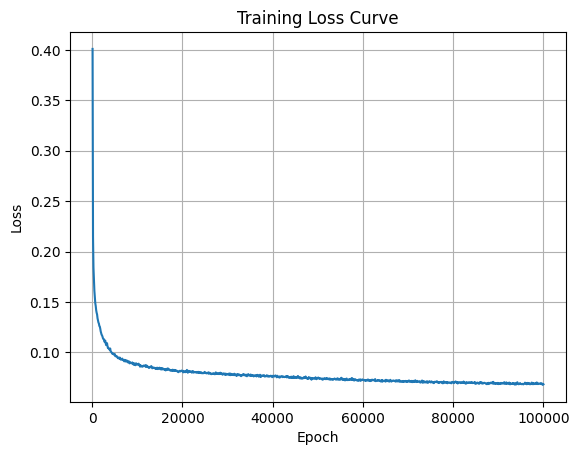

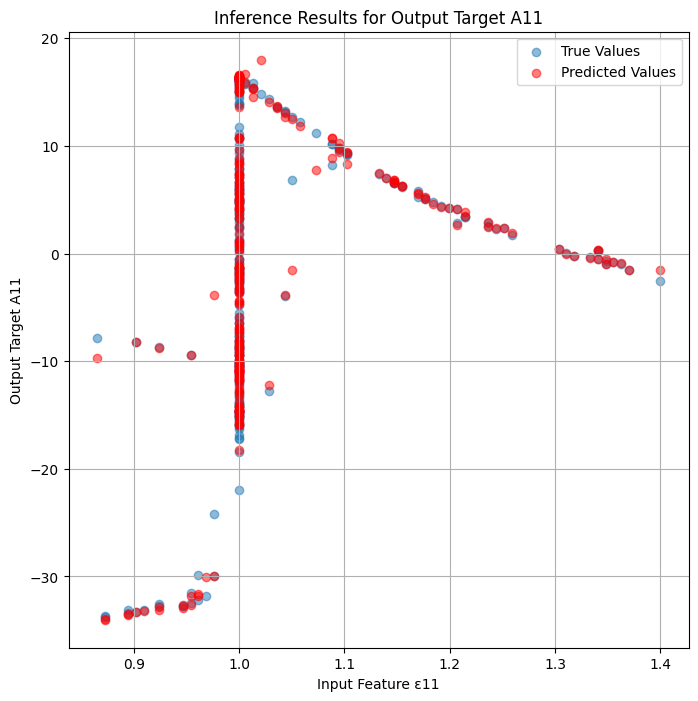

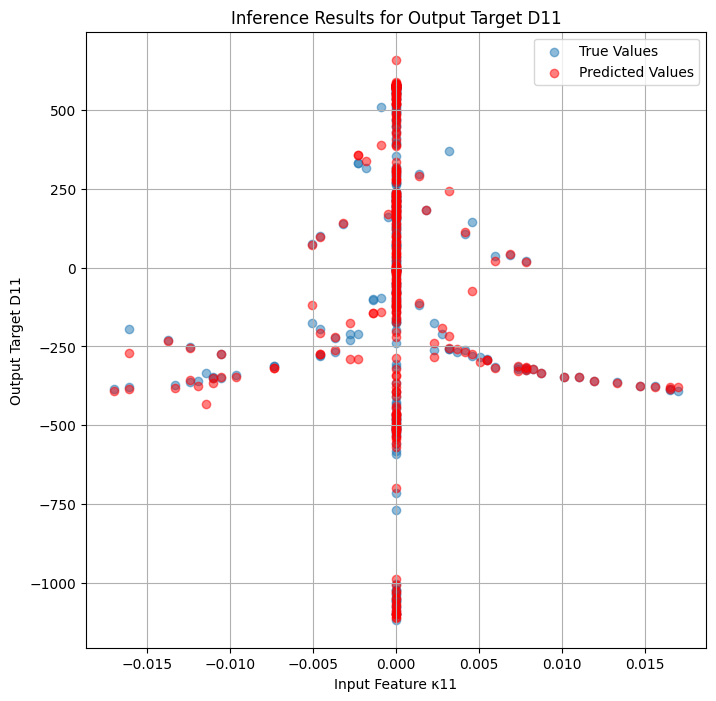

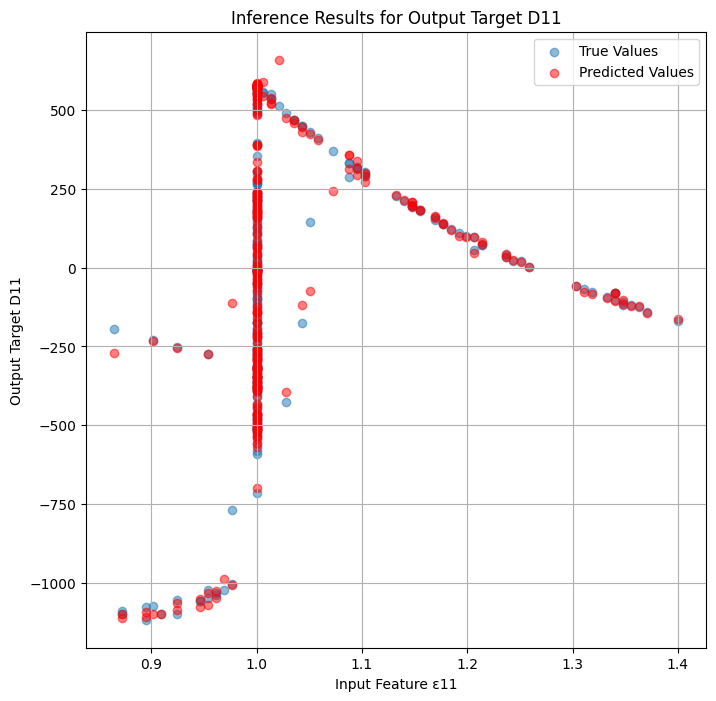

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_loss_curve(loss_values):
    plt.plot(loss_values[:, 0], loss_values[:, 1])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.grid()
    plt.show()

def plot_inference_results(xy_pred, xy_true, x_label, y_label, title='Inference', bool_line=False):
    plt.figure(figsize=(8, 8))
    plt.scatter(xy_true[0], xy_true[1], alpha=0.5, label='True Values')
    if bool_line:
        plt.plot(xy_pred[0], xy_pred[1], 'r--')
    else:
        plt.scatter(xy_pred[0], xy_pred[1], color='red', alpha=0.5, label='Predicted Values')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid()
    plt.legend()
    plt.show()

# evaluate the model on test set
def evaluate_model(model, X, Y):
    with torch.no_grad():
        test_outputs = model(X)
        criterion = nn.L1Loss()
        test_loss = criterion(test_outputs, Y)
    print(f'Test Loss: {test_loss.item():.4f}')

def plot_ABD_terms(x_index, y_index, model, Xte, Yte, bool_line=False):
    with torch.no_grad():
        if bool_line:
            x_test = torch.zeros((50, Xte.shape[1]), dtype=torch.float32).to(device)
            x_test[:, x_index] = torch.linspace(Xte[:, x_index].min(), Xte[:, x_index].max(), 50)
        else:
            x_test = Xte
        y_test = model(x_test)

    # scale back to prediction 
    x_test_scaled = x_test[:, x_index].cpu().numpy() * x_std[x_index] + x_mean[x_index]
    y_test_scaled = y_test[:, y_index].cpu().numpy() * y_std[y_index]

    # scale back to true values
    x_true = Xte[:, x_index].cpu().numpy() * x_std[x_index] + x_mean[x_index]
    y_true = Yte[:, y_index].cpu().numpy() * y_std[y_index]

    # plot inference results
    plot_inference_results(
        (x_test_scaled, y_test_scaled),
        (x_true, y_true),
        x_label=f'Input Feature {x_labels[x_index]}',
        y_label=f'Output Target {y_labels[y_index]}',
        title=f'Inference Results for Output Target {y_labels[y_index]}',
        bool_line=bool_line
    )


# model testing and visualization
for model_name in model_data.keys():
    print(f'Evaluating model: {model_name}')
    evaluate_model(model, Xte, Yte)
    plot_loss_curve(model_data[model_name])

    # a11 vs f11 plot
    x_index = 0
    y_index = 0
    plot_ABD_terms(x_index, y_index, model, Xte, Yte)

    # d11 vs g11 plot
    x_index = 5
    y_index = 12
    plot_ABD_terms(x_index, y_index, model, Xte, Yte)

    # d11 vs f11 plot
    x_index = 0
    y_index = 12
    plot_ABD_terms(x_index, y_index, model, Xte, Yte)